# Neural Networks

$\newcommand{\vec}{\mathbf}$
* Neural network is a function which takes a vector $\vec x$ with $n$ elements and produces an output $\vec y$ with $n_{ \mathrm out}$ elements
* Assume to have have $N$ samples of $\vec x$ and $\vec y$.
* For neural networks is it generally required to have a large sample

In [57]:
using Base.Test
using PyPlot

N = 1000; # number of samples
n = 2; # number of features
nout = 2
x = randn(n,N)


y = zeros(nout,N)

f(x) = x[1,:] + x[2,:] + 0. ./ (x[1,:].^2 + x[2,:].^2 + 0.3);

y[1,:] =x[1,:] + x[2,:];
y[1,:] =f(x);

y[2,:] = x[1,:] - x[2,:];

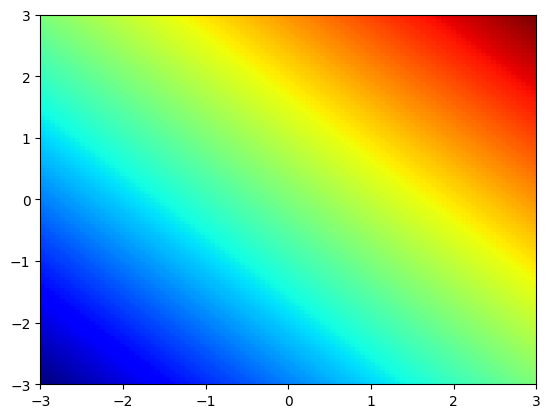

PyObject <matplotlib.collections.PolyCollection object at 0x7fda47aea210>

In [58]:
xmin = [-3, -3]
xmax = [3, 3]

gx = [px for px = linspace(xmin[1],xmax[1],100), py = linspace(xmin[2],xmax[2],100)]
gy = [py for px = linspace(xmin[1],xmax[1],100), py = linspace(xmin[2],xmax[2],100)]

gf = reshape(f([gx[:]'; gy[:]']),size(gx))
pcolor(gx,gy,gf)

In [59]:
srand(123)
nneurons = [n,20,20,nout]


#w = [randn(10,n),randn(nout,10)]
#b = [randn(10), randn(nout)]

4-element Array{Int64,1}:
  2
 20
 20
  2

In [60]:
n

2

In [61]:
function randnomwb(nneurons)
  w = Matrix{Float64}[]
  b = Vector{Float64}[]

  for i = 2:length(nneurons)
    push!(w,randn(nneurons[i],nneurons[i-1]))
    push!(b,randn(nneurons[i]))    
  end
    
  return w,b
end

w,b = randnomwb(nneurons)

(Array{Float64,2}[[1.19027 -0.979539; 2.04818 0.260402; … ; -0.71741 -0.253764; -0.77507 0.814027], [0.665752 -1.38107 … 0.360298 -0.576878; -0.920272 1.69266 … 0.11072 -0.703941; … ; 0.317881 -0.163711 … 0.351979 2.62354; 1.28493 -0.902986 … 0.973487 -0.899747], [0.593116 2.4333 … 0.0741321 0.463924; -0.264217 1.2888 … -1.50401 1.7808]], Array{Float64,1}[[-1.12484, -0.344396, -0.242498, 1.53199, 0.413443, -0.227612, -0.185849, 1.53182, -3.14326, -1.44006, 0.218713, -0.207285, 1.29264, 1.16967, 0.0307606, -1.14016, 0.434671, -0.314358, -0.548868, -0.635861], [-0.223793, -1.14511, 0.262751, -1.5859, -0.205003, 0.0820289, 1.73146, 1.57086, -0.42177, -1.84144, 0.8495, -0.092692, -0.830549, 0.954802, -0.865779, -0.766985, -0.906165, -0.993379, -1.48928, 1.12741], [0.173994, -0.529101]])

In [62]:
size.(b)

3-element Array{Tuple{Int64},1}:
 (20,)
 (20,)
 (2,) 

Activation functions and their derivative

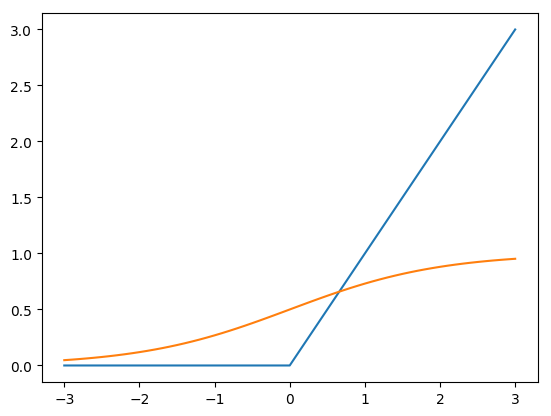

(∇sigmoid(0), (sigmoid(0.001) - sigmoid(0)) / 0.001) = (0.25, 0.2499999791666374)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda475c2150>

In [63]:
sigmoid(x) = 1/(1+exp(-x))
∇sigmoid(x) = exp(-x)/(1+exp(-x))^2

@show ∇sigmoid(0), (sigmoid(0.001) - sigmoid(0)) / 0.001

relu(x) = max(x,zero(x))
∇relu(x) = (x > 0 ? one(x) : zero(x))



xplot = -3:0.1:3
plot(xplot,relu.(xplot))
plot(xplot,sigmoid.(xplot))

In [64]:
size(b)

(3,)

In [65]:
activation(x) = sigmoid(x)
∇activation = ∇sigmoid

∇sigmoid (generic function with 1 method)

The loss functions defines how well of neural network reproduces the data
* for a regression problem the loss is often the L2 norm, representing how close the prediction $\vec y'$ are to the observations $\vec y$:

$$
J(\vec y') = || \vec y - \vec y' ||^2
$$

* if neural network predict probabilities, then it is common to use the negative log likelihood

In [66]:
loss(y,yp) = sum(abs2,y - yp)/length(y)
δloss(y,yp,δyp) = (sum((y - yp).^2 / length(y)), -2*δyp ⋅ (y - yp)/length(y))

δloss (generic function with 1 method)

In [67]:
size(x), size(w[1])

((2, 1000), (20, 2))

In [91]:
layer(w,b,x) = activation.(w*x .+ b)
δlayer(w,b,x,δw,δb,δx) = (activation.(w*x .+ b),∇activation.(w*x .+ b) .* (δb .+ (δw*x + w*δx)))

layer2(w,b,x) = w*x .+ b
δlayer2(w,b,x,δw,δb,δx) = (w*x .+ b, δb .+ (δw*x + w*δx))

const funs = [sigmoid,sigmoid,sigmoid]
const ∇funs = [∇sigmoid,∇sigmoid,∇sigmoid]



function predict(w::Vector{TA},b,x) where TA
    K = length(b)+1    
    yp = Vector{TA}(K)
    
    yp[1] = x    
    for i = 1:K-1
       yp[i+1] = funs[i].(layer2(w[i],b[i],yp[i]))
    end
    
    return yp[end]
end

function cost(w,b,x,y)    
    yp = predict(w,b,x)
    return loss(y,yp)
end

cost(w,b,x,y)

2.491309001427912

In [92]:
eps = 1e-4

δb = [eps*randn(size(tmp)) for tmp in b]
δw = [eps*randn(size(tmp)) for tmp in w]

b2 = [tmp + δtmp for (tmp,δtmp) in zip(b,δb)]
w2 = [tmp + δtmp for (tmp,δtmp) in zip(w,δw)]

J2 = cost(w2,b2,x,y) 

2.4912556769090544

In [93]:
cost(w,b,x,y)

2.491309001427912

In [94]:
δc_diff = (cost(w2,b2,x,y) 
         - cost(w,b,x,y)) / eps

function δpredict(w,b,x,δw,δb)
    K = length(b)+1
    
    yp = copy(x)
    δyp = zeros(x)
    for i = 1:K-2
       yp, δyp = δlayer(w[i],b[i],yp,δw[i],δb[i],δyp)
    end
    
    yp, δyp = δlayer(w[K-1],b[K-1],yp,δw[K-1],δb[K-1],δyp)
    return yp,δyp 
end

function δcost(w,b,x,y,δw,δb)
    yp, δyp = δpredict(w,b,x,δw,δb)
    return δloss(y,yp,δyp)
end


J,δJ =  δcost(w,b,x,y,δw,δb)

@test δc_diff ≈ δJ/eps rtol=1e-2
#@show δc_diff
#@show δJ/eps

Test Passed

Adjoint

In [101]:
∂J = 1.

t1 = ∂J * δcost(w,b,x,y,δw,δb)[2]

function adj_loss(y,yp,∂J)
    ∂yp = -2 * (y - yp) * ∂J / length(y)
end

function adj_layer2(w,b,x,∂yp)
    #δlayer2(w,b,x,δw,δb,δx) = (w*x .+ b, δb .+ (δw*x + w*δx))

    
    ∂b = sum(∂yp,2)[:,1]
    ∂w = (∂yp) * x'
    ∂x = w' * ∂yp
    
    return ∂w,∂b,∂x
end


function adj_layer(w,b,x,∂yp)
    ∇act = ∇activation.(w*x .+ b)
    ∂b = sum(∇act .* ∂yp,2)[:,1]
    ∂w = (∇act .* ∂yp) * x'
    ∂x = w' * (∇act .* ∂yp)
    
    return ∂w,∂b,∂x
end

function adj_cost(w::Vector{Matrix{T}},b::Vector{Vector{T}},x,y,δJ) where T
    N = length(b)
    yp = Vector{Matrix{T}}(N+1)
    ∂yp = Vector{Matrix{T}}(N+1)
    ∂w = Vector{Matrix{T}}(N)
    ∂b = Vector{Vector{T}}(N)
    
    # prediction - foreward
    yp[1] = x
    for i = 1:N
      yp[i+1] = funs[i].(layer2(w[i],b[i],yp[i]))
    end
    
    # back-propagation
    # now everything in reverse
    ∂yp[N+1] = adj_loss(y,yp[N+1],∂J)
    
    for i = N:-1:1
       ∇act = ∇funs[i].(w[i]*yp[i] .+ b[i])
       ∂yp[i+1] = ∇act .* ∂yp[i+1]
       ∂w[i],∂b[i],∂yp[i] = adj_layer2(w[i],b[i],yp[i],∂yp[i+1])
    end
    
    return ∂w,∂b
end


∂w,∂b = adj_cost(w,b,x,y,∂J)

t2 = 0.
for i = 1:length(b)
    t2 = t2 + ∂w[i] ⋅ δw[i] + ∂b[i] ⋅ δb[i]
end

@test t1  ≈ t2

Test Passed

Gradient descent


In [98]:
@show cost(w,b,x,y)

cost(w, b, x, y) = 2.491309001427912


2.491309001427912

In [99]:
@show cost(w,b,x,y)

η = 0.2 # learning rate

# compute the gradient
∂w,∂b = adj_cost(w,b,x,y,1.)

# update weights and biases
for i = 1:length(w)
    w[i] = w[i] - η * ∂w[i]
    b[i] = b[i] - η * ∂b[i]
end
@show cost(w,b,x,y)


cost(w, b, x, y) = 2.491309001427912
cost(w, b, x, y) = 2.458164722945265


2.458164722945265

In [44]:
batchsize = 50
ibatch = randperm(N)[1:batchsize]

50-element Array{Int64,1}:
 137
 645
 543
  64
 218
 509
 322
 925
 284
 494
  33
 244
 895
   ⋮
 417
 226
 229
 964
 601
 539
 326
 127
 832
 922
 405
 791

In [19]:
@show cost(w,b,x,y)
Niter = 1000
η = 0.2 # learning rate
C = zeros(Niter+1)


for k = 1:Niter
    C[k] = cost(w,b,x,y)
    
    # compute the gradient
    ∂w,∂b = adj_cost(w,b,x,y,1.)
    
    # update weights and biases
    for i = 1:length(w)
      w[i] = w[i] - η * ∂w[i]
      b[i] = b[i] - η * ∂b[i]
    end  
end
C[Niter+1] = cost(w,b,x,y)

cost(w, b, x, y) = 2.601083716477106


1.368127617064128

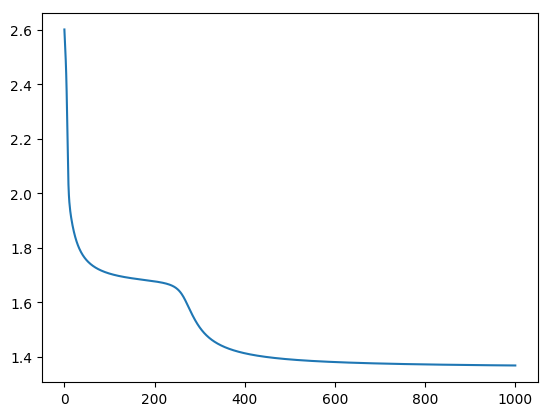

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda54207b90>

In [20]:
plot(C)

In [55]:
w,b = randnomwb(nneurons)

@show cost(w,b,x,y)
Niter = 1000
η = 0.2 # learning rate
C = zeros(Niter+1)


for k = 1:Niter
    C[k] = cost(w,b,x,y)
    
    
    ibatch = randperm(N)[1:batchsize]
    
    # compute the gradient
    ∂w,∂b = adj_cost(w,b,x[:,ibatch],y[:,ibatch],1.)
    
    # update weights and biases
    for i = 1:length(w)
      w[i] = w[i] - η * ∂w[i]
      b[i] = b[i] - η * ∂b[i]
    end  
end
C[Niter+1] = cost(w,b,x,y)

cost(w, b, x, y) = 2.4265593569163437


1.3705085721189385

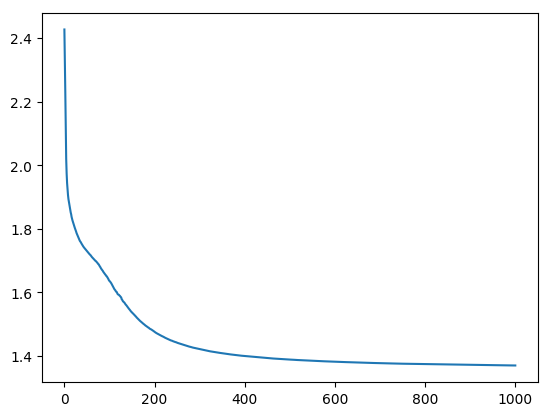

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fda47b70890>

In [56]:
plot(C)

In [21]:
predict(w,b,x)

2×1000 Array{Float64,2}:
 0.994339  0.00338536  0.927798   …  0.983474  0.0028475  0.030158   
 0.448782  0.00157464  0.0418474     0.825191  0.020017   0.000653486

In [22]:
y

2×1000 Array{Float64,2}:
 2.22957  -1.0702   0.954685  0.109736  …  1.643     -0.975032  -0.298707
 0.47842  -1.1053  -0.145002  1.17745      0.788705  -0.224005  -1.50264 

In [23]:
i=1;j=1
[gx[i,j]; gy[i,j]][2,:]

1-element Array{Float64,1}:
 -3.0

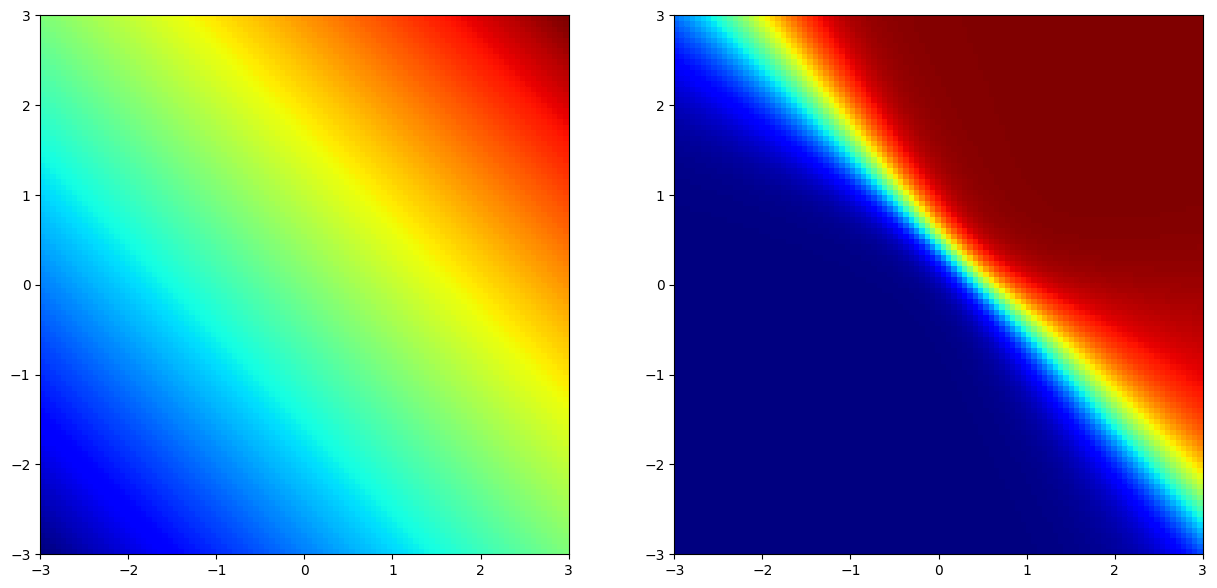

PyObject <matplotlib.collections.PolyCollection object at 0x7fda4fca3c50>

In [24]:
gf2 = zeros(size(gx))
for j = 1:size(gx,2)
   for i = 1:size(gx,1)
        gf2[i,j] = predict(w,b,reshape([gx[i,j]; gy[i,j]],(2,1)))[1]
    end
end

fig = figure(figsize=(15,7))
subplot(1,2,1)
pcolor(gx,gy,gf)

subplot(1,2,2)
pcolor(gx,gy,gf2)

Can we avoid to write gradient and ajoint of your neural network by-hand?
* yes we can using e.g. ReverseDiff
* However, we cannot use a vector of vectors (`b`) and vectors of matrices (`w`).
* We have to pack (or `flatten`), all these quantities into a long vector

In [25]:
#Pkg.add("ReverseDiff")

In [26]:
packwb(w,b) = cat(1,b..., collect.(Iterators.flatten.(w))...)

packwb (generic function with 1 method)

In [27]:
wb = packwb(w,b)
size.(b)
wb

522-element Array{Float64,1}:
 -1.4099     
 -0.263227   
 -0.274845   
  0.805146   
  0.51208    
  0.323263   
 -0.227582   
  1.7013     
 -3.30096    
 -1.43805    
  0.0651134  
  0.0971255  
  1.27812    
  ⋮          
 -1.19224    
  0.0700597  
  1.07251    
  0.0428749  
  0.116892   
 -0.000516798
 -0.74932    
 -0.216808   
  0.227511   
 -1.79829    
  0.792707   
  2.28313    

And we need to provide the inverse function

In [28]:
function unpackwb(wb::TA,nneurons) where TA
    b = TA[]
    w = []
    j = 0
    for i = 1:length(nneurons)-1
        push!(b,wb[j+1:j+nneurons[i+1]])
        j += +nneurons[i+1]
    end
    for i = 1:length(nneurons)-1
        push!(w,reshape(wb[j+1:j + nneurons[i+1] * nneurons[i]],(nneurons[i+1],nneurons[i])))
        j += +nneurons[i] * nneurons[i+1]
    end
    
    return w,b
end
  

unpackwb (generic function with 1 method)

Packing and unpacking should return the original data

In [29]:
  
w2, b2 = unpackwb(wb,nneurons)
@test b2 == b

Test Passed

In [30]:
@test w2 == w

Test Passed

In [31]:
nneurons

4-element Array{Int64,1}:
  2
 20
 20
  2

In [32]:
size.(w)

3-element Array{Tuple{Int64,Int64},1}:
 (20, 2) 
 (20, 20)
 (2, 20) 

In [33]:
using ReverseDiff: GradientTape, GradientConfig, gradient, gradient!, compile

In [34]:
function costwb(wb)
    w,b = unpackwb(wb,nneurons)
    return cost(w,b,x,y)
end

const f_tape = GradientTape(costwb, (wb,))
const compiled_f_tape = compile(f_tape)
#extrema(results)

function adj_cost2(w,b)
    wb = packwb(w,b)
    results = (similar(wb),)
    gradient!(results, compiled_f_tape, (wb,))
    return unpackwb(results[1],nneurons)
end
#maximum(gradient(costwb,(wb,))[1])

#results = gradient(costwb,(wb,))[1]

grad = (similar(wb),)

#f_tape2 = GradientTape(costwb, (wb,))
gradient!(grad, compiled_f_tape, (wb,))


([0.000109755, 8.47548e-5, 3.18883e-5, 0.000688193, -0.000372602, -0.000792691, 0.000200986, 9.00839e-5, 4.47616e-5, 8.82213e-5  …  -3.11588e-5, 0.000192046, -0.000698245, -0.000902579, 0.000567784, -0.000529978, -1.5739e-5, 0.000771934, -0.000571122, -0.00136754],)

In [35]:
e = zeros(size(wb))
e[1,1] = 1

@test (costwb(wb+eps*e) - costwb(wb))/eps ≈ grad[1][1] rtol=1e-3


Test Passed

In [36]:
rwb = randn(size(wb))

@test (costwb(wb + eps*rwb) - costwb(wb - eps*rwb))/(2eps) ≈ sum(rwb .* grad[1]) rtol=1e-3


Test Passed

In [37]:
∂w,∂b = adj_cost(w,b,x,y,1.)
∂w2,∂b2 = adj_cost2(w,b)

@test ∂w ≈ ∂w2
@test ∂b ≈ ∂b2


Test Passed